Mounting Google Drive

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Session 7')

In [ ]:

pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Rashi Agarwal\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Importing libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Updating Device to CUDA

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [5]:
import utils
import model

In [6]:
from utils import   (
 plot_graphs,
 plots,
 plt,
 torch,
 tqdm
 )

In [7]:
from model import (F,
  Net,nn,torch)

Defining data tranformations

In [8]:
train_transforms = transforms.Compose([
   #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    #transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


Downloading MNIST dataset and splitting to train and test set

In [9]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 107780857.32it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98404300.43it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23252633.94it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21238047.68it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Creating Data Loaders from train data and test data

In [10]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

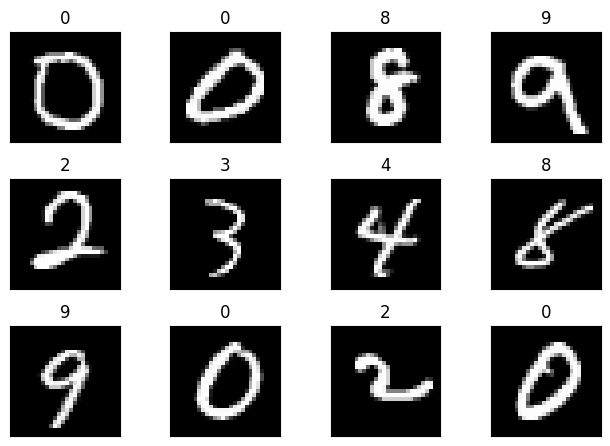

In [ ]:
plots(train_loader)

## Data Statistics

torch.Size([512, 1, 28, 28])
torch.Size([512])


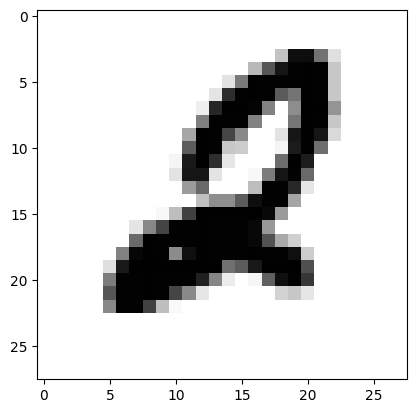

In [ ]:
# train_data1 = train_data.train_data
# train_data = train_data.transform(train_data1.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_data.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

Viewing images

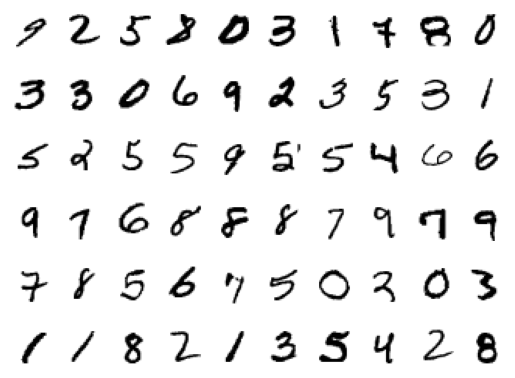

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Transferring model to GPU and printing model summary

In [11]:
model1 = Net().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             900
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14           [-1, 16,

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.5938851237297058 Batch_id=117 Accuracy=71.34: 100%|██████████| 118/118 [00:14<00:00,  8.04it/s]



Test set: Average loss: 0.5088, Accuracy: 9311/10000 (93.11%)

EPOCH: 1


Loss=0.30466994643211365 Batch_id=117 Accuracy=94.19: 100%|██████████| 118/118 [00:14<00:00,  8.12it/s]



Test set: Average loss: 0.2288, Accuracy: 9640/10000 (96.40%)

EPOCH: 2


Loss=0.22312627732753754 Batch_id=117 Accuracy=96.27: 100%|██████████| 118/118 [00:14<00:00,  8.08it/s]



Test set: Average loss: 0.1469, Accuracy: 9755/10000 (97.55%)

EPOCH: 3


Loss=0.18794195353984833 Batch_id=117 Accuracy=97.10: 100%|██████████| 118/118 [00:14<00:00,  8.05it/s]



Test set: Average loss: 0.1078, Accuracy: 9791/10000 (97.91%)

EPOCH: 4


Loss=0.11368239670991898 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:14<00:00,  7.98it/s]



Test set: Average loss: 0.0910, Accuracy: 9816/10000 (98.16%)

EPOCH: 5


Loss=0.1535947471857071 Batch_id=117 Accuracy=97.74: 100%|██████████| 118/118 [00:17<00:00,  6.93it/s]



Test set: Average loss: 0.0957, Accuracy: 9793/10000 (97.93%)

EPOCH: 6


Loss=0.10540419071912766 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:14<00:00,  7.95it/s]



Test set: Average loss: 0.0737, Accuracy: 9839/10000 (98.39%)

EPOCH: 7


Loss=0.04504456743597984 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:15<00:00,  7.60it/s]



Test set: Average loss: 0.0646, Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.08339684456586838 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:15<00:00,  7.83it/s]



Test set: Average loss: 0.0588, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.08239879459142685 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:14<00:00,  7.91it/s]



Test set: Average loss: 0.0639, Accuracy: 9860/10000 (98.60%)

EPOCH: 10


Loss=0.06479443609714508 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:14<00:00,  7.99it/s]



Test set: Average loss: 0.0548, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.11369521170854568 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:15<00:00,  7.75it/s]



Test set: Average loss: 0.0506, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.08479586988687515 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:16<00:00,  7.11it/s]



Test set: Average loss: 0.0478, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.056848783046007156 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:14<00:00,  7.93it/s]



Test set: Average loss: 0.0479, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.09896848350763321 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:14<00:00,  7.98it/s]



Test set: Average loss: 0.0437, Accuracy: 9893/10000 (98.93%)



In [1]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

NameError: ignored

# Target:

After Batch Normalization , Dropout layers, Introducing Max pooling at RF 5 to increase accuracy of the model

# Results:
Parameters: 6K

Best Training Accuracy: 98.6

Best Test Accuracy: 98.9

# Analysis:
Light Model but working

Model is good but is slightly under-fitting.

We need to enhance the parameters/layers to improve our training